In [1]:
import numpy as np
from cvxopt import matrix, solvers,modeling
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
class action:
    def __init__(self,value):
        self.value = value
    def result(self,input_pos):
        if self.value == 0: #North      
            output_pos = (input_pos[0] if input_pos[0] == 0 else input_pos[0] -1,input_pos[1])
        elif self.value == 1: #South
            output_pos = (input_pos[0] if input_pos[0] == 1 else input_pos[0] + 1,input_pos[1])
        elif self.value == 2: #East
            output_pos = (input_pos[0],input_pos[1] if input_pos[1] == 3 else input_pos[1] + 1)
        elif self.value == 3: #West
            output_pos = (input_pos[0],input_pos[1] if input_pos[1] == 0 else input_pos[1] - 1)
        else: #Stick
            output_pos = (input_pos[0],input_pos[1])
        return output_pos

In [3]:
class soccer_action_space:
    def __init__(self):
        self.n = 5
        self.actions = [action(0),action(1),action(2),action(3),action(4)]
    def sample(self):
        first_action = np.random.choice(self.actions)
        second_action = np.random.choice(self.actions) 
        return (first_action,second_action)

In [4]:
class state:
    state_id_mapping = {}
    i=0
    for a in range(2):
        for b in range(4):
            for c in range(2):
                for d in range(4):
                    for e in range(2):
                        state_id_mapping[(a,b,c,d,e)] = i
                        i += 1
    def __init__(self,player0_pos,player1_pos,ball_possession,id_mapping = state_id_mapping):
        self.player0_pos = player0_pos
        self.player1_pos = player1_pos
        self.ball_possession = ball_possession  
        self.value = (self.player0_pos[0],self.player0_pos[1],self.player1_pos[0],self.player1_pos[1],ball_possession)
        self.id = id_mapping[self.value]          

In [5]:
class soccer_observation_space:
    def __init__(self):
        self.shape = [128,5]

In [6]:
class SoccerGame:
    def __init__(self):
        self.action_space = soccer_action_space()
        self.observation_space = soccer_observation_space()
        self.reward = None
        self.done = False
    def reset(self):
        return state((0,2),(0,1),1)
    
    def get_action_output(self,first_mover_action,second_mover_action,first_mover_pos
                          ,second_mover_pos,first_mover_ball_possession):
        
        ## First Player Move from first_mover_pos to first_mover_target_pos
        first_mover_target_pos = first_mover_action.result(first_mover_pos)
        if first_mover_target_pos == second_mover_pos:
            first_mover_ball_possession = 0             
        else:
            first_mover_pos = first_mover_target_pos
            
        ## Second Player Move from second_mover_pos to second_mover_target_pos
        second_mover_target_pos = second_mover_action.result(second_mover_pos)
        if second_mover_target_pos == first_mover_pos:
            first_mover_ball_possession = 1            
        else:
            second_mover_pos = second_mover_target_pos
            
        return first_mover_pos,second_mover_pos,first_mover_ball_possession
        
    def step(self,actions,current_state):
        if np.random.rand() > 0.5: # Player A makes first move
            first_mover_action = actions[0]
            second_mover_action = actions[1]
            
            first_mover_pos = current_state.player0_pos
            second_mover_pos = current_state.player1_pos
            
            first_mover_ball_possession = 1 if current_state.ball_possession == 0 else 0
            
            first_mover_pos,second_mover_pos,first_mover_ball_possession = self.get_action_output(first_mover_action
                                                                                        ,second_mover_action
                                                                                        ,first_mover_pos
                                                                                        ,second_mover_pos
                                                                                        ,first_mover_ball_possession)
            ball_possession = 0 if first_mover_ball_possession == 1 else 1
            next_state = state(first_mover_pos,second_mover_pos,ball_possession)
        else: # Player B makes first move
            first_mover_action = actions[1]
            second_mover_action = actions[0]
            
            first_mover_pos = current_state.player1_pos
            second_mover_pos = current_state.player0_pos
            
            first_mover_ball_possession = 1 if current_state.ball_possession == 1 else 0
            
            first_mover_pos,second_mover_pos,first_mover_ball_possession = self.get_action_output(first_mover_action
                                                                                        ,second_mover_action
                                                                                        ,first_mover_pos
                                                                                        ,second_mover_pos
                                                                                        ,first_mover_ball_possession)
            ball_possession = 1 if first_mover_ball_possession == 1 else 0
            next_state = state(second_mover_pos,first_mover_pos,ball_possession)  
            
        ball_column = next_state.player0_pos[1] if next_state.ball_possession == 0 else next_state.player1_pos[1]  
        if  ball_column == 0:
            reward = 100
            done = True
        elif ball_column == 3:
            reward = -100
            done = True
        else:
            reward = 0
            done = False
        
        return next_state,reward,done,None

In [7]:
env = SoccerGame()
steps = 1e6
current_step = 0
alpha = 1
alpha_decay = 0.999995
gamma = 0.9
epsilon = 1
epsilon_decay = 0.999995
step_list = []
error_list = []
Q = np.zeros((128,5))
while current_step < steps:
    current_state = env.reset()
    done = False
    while not done:         
        Player1_random_action,Player2_random_action = env.action_space.sample()
              
        Player1_greedy_action = env.action_space.actions[np.argmax(Q[current_state.id])]
                  
        current_action = (Player1_random_action,Player2_random_action) if np.random.random() < epsilon else (Player1_greedy_action,Player2_random_action)
        
        next_state, reward, done, _ = env.step(current_action,current_state) 
        
        Player1_V = np.max(Q[next_state.id,:])
       
        Q_before = Q[current_state.id,current_action[0].value]
        Q[current_state.id,current_action[0].value] = Q[current_state.id,current_action[0].value] + alpha * (reward + gamma * Player1_V - Q[current_state.id,current_action[0].value])
        Q_after = Q[current_state.id,current_action[0].value]

        
        error = Q_after-Q_before
        if current_state.value == (0,2,0,1,1) and current_action[0].value == 1:
            step_list.append(current_step)
            error = 0 if error < 0 else error
            error_list.append(abs(error))
        current_state = next_state
        current_step += 1
        if current_step %10000 == 0:
            print(f'{current_step} steps completed.')
        epsilon = epsilon * epsilon_decay if epsilon > 0.001 else epsilon   
        alpha = alpha * alpha_decay if alpha > 0.001 else alpha 
    
output_df = pd.DataFrame({'Step':step_list,'Error':error_list})

10000 steps completed.
20000 steps completed.
30000 steps completed.
40000 steps completed.
50000 steps completed.
60000 steps completed.
70000 steps completed.
80000 steps completed.
90000 steps completed.
100000 steps completed.
110000 steps completed.
120000 steps completed.
130000 steps completed.
140000 steps completed.
150000 steps completed.
160000 steps completed.
170000 steps completed.
180000 steps completed.
190000 steps completed.
200000 steps completed.
210000 steps completed.
220000 steps completed.
230000 steps completed.
240000 steps completed.
250000 steps completed.
260000 steps completed.
270000 steps completed.
280000 steps completed.
290000 steps completed.
300000 steps completed.
310000 steps completed.
320000 steps completed.
330000 steps completed.
340000 steps completed.
350000 steps completed.
360000 steps completed.
370000 steps completed.
380000 steps completed.
390000 steps completed.
400000 steps completed.
410000 steps completed.
420000 steps completed.
4

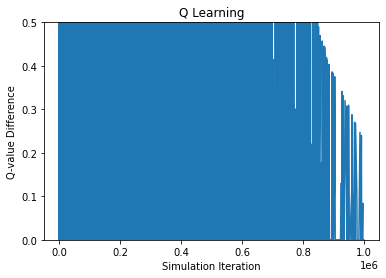

In [8]:
plt.title("Q Learning")
plt.xlabel('Simulation Iteration')
plt.ylabel('Q-value Difference')
plt.ylim(0, 0.5)
plt.plot(output_df['Step'],output_df['Error'])
plt.savefig("Q.png")